# Antarctic shelf versus open ocean

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import os
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from xwmt.swmt import swmt
from xwmt.compute import lbin_define

In [3]:
import sys
sys.path.append('../scripts')
from preprocessing import preprocessing

In [4]:
outdir='/scratch/gpfs/jt7058/GFDL/fafmip/netcdf/'
zarrdir='/scratch/gpfs/jt7058/GFDL/fafmip/'

mod = 'CM4' # CM4, ESM4
exp = 'antwater' # control, antwater, stress, antwaterstress
mem = 251 # 251, 290, 332 (CM4) / 101, 151, 201 (ESM4)

In [5]:
file_path = os.path.join(zarrdir,'zarr',mod,exp,'monthly') if exp=='control' \
            else os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
print(file_path)
ds = xr.open_zarr(file_path)

/scratch/gpfs/jt7058/GFDL/fafmip/zarr/CM4/antwater/251/monthly


In [6]:
ds

<xarray.Dataset>
Dimensions:                 (nv: 2, time: 1200, xh: 1440, yh: 1080)
Coordinates:
  * nv                      (nv) float64 1.0 2.0
  * time                    (time) object 0001-01-16 12:00:00 ... 0100-12-16 ...
  * xh                      (xh) float64 -299.7 -299.5 -299.2 ... 59.78 60.03
  * yh                      (yh) float64 -80.39 -80.31 -80.23 ... 89.84 89.95
Data variables:
    evs                     (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ficeberg                (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    friver                  (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    heat_content_surfwater  (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hfds                    (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hflso                   (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hfsifrazil              (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hfsso                   (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    prlq                    (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    prsn                    (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    rlntds                  (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    rsntds                  (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    sfdsi                   (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    sos                     (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    time_bnds               (time, nv) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    tos                     (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    wfo                     (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 00010101.ocean_static.nc
    external_variables:  areacello
    filename:            ocean_monthly.000101-000512.evs.nc
    grid_tile:           N/A
    grid_type:           regular
    title:               CM4_piControl_C_fafantwater

In [6]:
rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/'
pp = 'ocean_monthly'

if mod == 'CM4':
    subdir = 'CM4_piControl_C'
    grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
    shlf_mask = xr.open_dataset(rootdir[:-11]+'CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                    .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
elif mod == 'ESM4':
    subdir = 'ESM4_piControl_D'
    grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
    shlf_mask = xr.open_dataset(rootdir[:-11]+'ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                    .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
else:
    print('grid is not available for '+subdir)

In [7]:
ds = preprocessing(ds, grid, decode_times=False, verbose=False)

In [8]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0251-01-16 to 0395-12-16


In [9]:
# Subselect Southern Ocean
#north = -30.0
north = -60.0

onshlf = ds.drop_dims('nv').where(shlf_mask==1,drop=True).where(ds.lat<north,drop=True)
if north<-60:
    offshr = ds.drop_dims('nv').where(shlf_mask!=1,drop=True).where(ds.lat<north,drop=True)
else:
    offshr = ds.drop_dims('nv')\
        .where(xr.concat([shlf_mask, xr.zeros_like(ds.wet)\
                          .isel(y=slice(len(shlf_mask.y), None))], 
                         dim='y')!=1,drop=True).where(ds.lat<north,drop=True)
onshlf['time_bnds'] = ds.time_bnds
offshr['time_bnds'] = ds.time_bnds

In [10]:
#lstr = 'sigma0'
#dl,sigi,sigf = 0.02, 26.01 , 28.49
#dl,sigi,sigf = 0.05, 25.0 , 28.5

#lstr = 'sigma1'
#dl,sigi,sigf = 0.02, 31.01 , 33.49
#dl,sigi,sigf = 0.05, 30.0 , 33.5
#dl,sigi,sigf = 0.3, 31.55 , 32.15

lstr = 'sigma2'
dl,sigi,sigf = 0.02, 35.41, 37.89
#dl,sigi,sigf = 0.05, 34.0 , 38.0
#dl,sigi,sigf = 0.125, 34.0625 , 36.8125

lbins = lbin_define(sigi,sigf,dl)

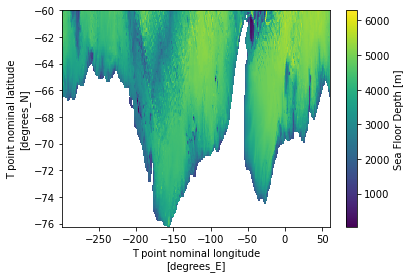

In [11]:
offshr.deptho.plot()

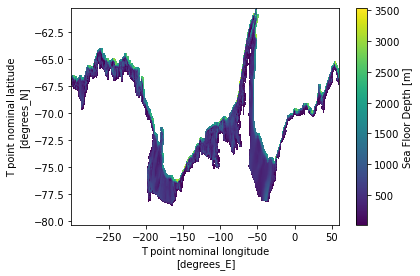

In [12]:
onshlf.deptho.plot()

In [13]:
# Initialize 2D surface WMT class
if 'lev' in list(ds.dims.keys()):
    dd_srf_onshlf = swmt(onshlf.drop_dims(['lev','lev_outer']))
    dd_srf_offshr = swmt(offshr.drop_dims(['lev','lev_outer']))
else:
    dd_srf_onshlf = swmt(onshlf)
    dd_srf_offshr = swmt(offshr)

In [14]:
if mod=='CM4':
    if exp=='control':
        yr_st,yr_ed = '0281','0380'
    else:
        yr_st,yr_ed = '0051','0070'
elif mod=='ESM4':
    if exp=='control':
        yr_st,yr_ed = '0121','0220'
    elif mem==101:
        yr_st,yr_ed = '0151','0170'
    else:
        yr_st,yr_ed = '0051','0070'

In [15]:
dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins).to_dataset(name='onshlf').reset_coords(drop=True)

In [16]:
dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins).to_dataset(name='offshr').reset_coords(drop=True)

In [17]:
dsG = xr.merge([dsG_onshlf,dsG_offshr])

In [18]:
var = 'swmt' # wmt
dl_str = str(dl).replace('.','').ljust(3, '0')
#dl_str = 'lores'

head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
fname = head+'_so_%sto%s_southof%sS_%s_onvoffshelf_%s_%s.nc'\
        %(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
#with ProgressBar():
#    dsG.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_control_so_0251to0395_southof600S_swmt_onvoffshelf_sigma2_002.nc


In [19]:
dsG = xr.open_dataset(outdir+fname).sel(time=slice(yr_st,yr_ed))

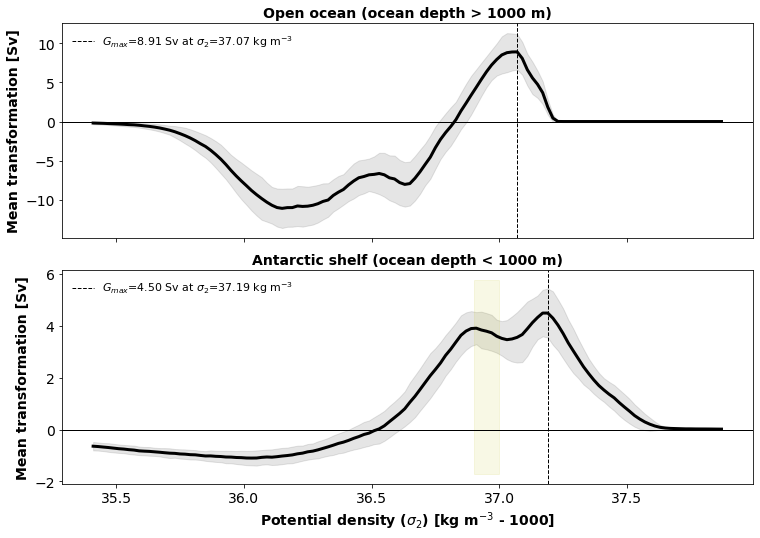

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)
for i, reg in enumerate(['offshr','onshlf']):
    
    axs[i].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
    
    axs[i].fill_between(dsG.coords[lstr], 
                        (dsG[reg].mean('time')-dsG[reg].groupby('time.year').mean('time').std('year'))*1e-6, 
                        (dsG[reg].mean('time')+dsG[reg].groupby('time.year').mean('time').std('year'))*1e-6, 
                        alpha=0.1, edgecolor='k', facecolor='k')
    axs[i].plot(dsG.coords[lstr], dsG[reg].mean('time')*1e-6, lw=3, c='k', ls='-',label=None)
    
    sig_max = np.round(dsG[reg].mean('time')[dsG[reg].mean('time').argmax()][lstr].values,2)
    G_max = np.round(dsG[reg].mean('time')[dsG[reg].mean('time').argmax()].values*1e-6,2)
    axs[i].axvline(x=sig_max, c = 'k', ls='--', lw=1, 
                   label=r'$G_{max}$=%.2f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(G_max,lstr[-1],sig_max))
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_ylabel('Mean transformation [Sv]',fontsize=14,fontweight='bold')
    axs[i].legend(loc='upper left', ncol=1, fontsize=11,frameon=False)
    
axs[0].set_xticklabels([])
axs[0].set_title('Open ocean (ocean depth > 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_title('Antarctic shelf (ocean depth < 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14,fontweight='bold')

val, dl = 36.95, 0.1
ylim = axs[1].get_ylim()
axs[1].fill([val-dl/2,val+dl/2,val+dl/2,val-dl/2],[ylim[0],ylim[0],ylim[1],ylim[1]],fill=True,c='y',alpha=0.1)
plt.show()

In [17]:
for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            ds = xr.open_zarr(file_path)
            
            if mod == 'CM4':
                subdir = 'CM4_piControl_C'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
            elif mod == 'ESM4':
                subdir = 'ESM4_piControl_D'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
                
            ds = preprocessing(ds, grid, decode_times=False, verbose=False)
            
            onshlf = ds.drop_dims('nv').where(shlf_mask==1,drop=True).where(ds.lat<north,drop=True)
            
            if north<-60:
                offshr = ds.drop_dims('nv').where(shlf_mask!=1,drop=True).where(ds.lat<north,drop=True)
            else:
                offshr = ds.drop_dims('nv')\
                            .where(xr.concat([shlf_mask, xr.zeros_like(ds.wet)\
                                              .isel(y=slice(len(shlf_mask.y), None))], 
                                             dim='y')!=1,drop=True).where(ds.lat<north,drop=True)
            onshlf['time_bnds'] = ds.time_bnds
            offshr['time_bnds'] = ds.time_bnds
            
            # Initialize 2D surface WMT class
            if 'lev' in list(ds.dims.keys()):
                dd_srf_onshlf = swmt(onshlf.drop_dims(['lev','lev_outer']))
                dd_srf_offshr = swmt(offshr.drop_dims(['lev','lev_outer']))
            else:
                dd_srf_onshlf = swmt(onshlf)
                dd_srf_offshr = swmt(offshr)
                
            dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins).to_dataset(name='onshlf').reset_coords(drop=True)
            dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins).to_dataset(name='offshr').reset_coords(drop=True)
            dsG = xr.merge([dsG_onshlf,dsG_offshr])
            
            head = '%s_%s_%s'%(mod,exp,str(mem))
            fname = head+'_so_%sto%s_southof%sS_%s_onvoffshelf_%s_%s.nc'\
                        %(str(ds.time.dt.year[0].values).rjust(4, '0'),
                          str(ds.time.dt.year[-1].values).rjust(4, '0'),
                          str(abs(north)).replace('.',''), var, lstr, dl_str)
            
            print('Saving to file:', fname)
            with ProgressBar():
                dsG.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_antwater_251_so_0001to0100_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  6min 47.4s
Saving to file: CM4_antwater_290_so_0001to0070_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  4min 44.1s
Saving to file: CM4_antwater_332_so_0001to0070_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  4min 44.0s
Saving to file: CM4_stress_251_so_0001to0100_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  6min 45.5s
Saving to file: CM4_stress_290_so_0001to0070_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  4min 42.6s
Saving to file: CM4_stress_332_so_0001to0070_southof600S_swmt_onvoffshelf_sigma2_002.nc
[########################################] | 100% Completed |  4min 42.2s
Saving to file: CM4_an

## Decompose into thermal and haline components

In [16]:
dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins, group_tend=False)
dsG_onshlf['total'] = dsG_onshlf.heat+dsG_onshlf.salt

dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins, group_tend=False)
dsG_offshr['total'] = dsG_offshr.heat+dsG_offshr.salt

In [17]:
for vstr in list(dsG_onshlf.data_vars):
    dsG_onshlf = dsG_onshlf.rename({vstr:'onshlf_'+vstr})
    dsG_offshr = dsG_offshr.rename({vstr:'offshr_'+vstr})
dsG = xr.merge([dsG_onshlf,dsG_offshr])

In [18]:
var = 'swmt' # wmt
dl_str = str(dl).replace('.','').ljust(3, '0')
#dl_str = 'lores'
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))

fname = head+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_%s_%s.nc'\
        %(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), var, lstr, dl_str)
print('Saving to file:', fname)
with ProgressBar():
    dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_control_so_0101to0270_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  6min 54.2s


In [20]:
dsG = xr.open_dataset(outdir+fname).sel(time=slice(yr_st,yr_ed))
G_mean = dsG.mean('time')*1e-6
G_std = dsG.groupby('time.year').mean('time').std('year')*1e-6

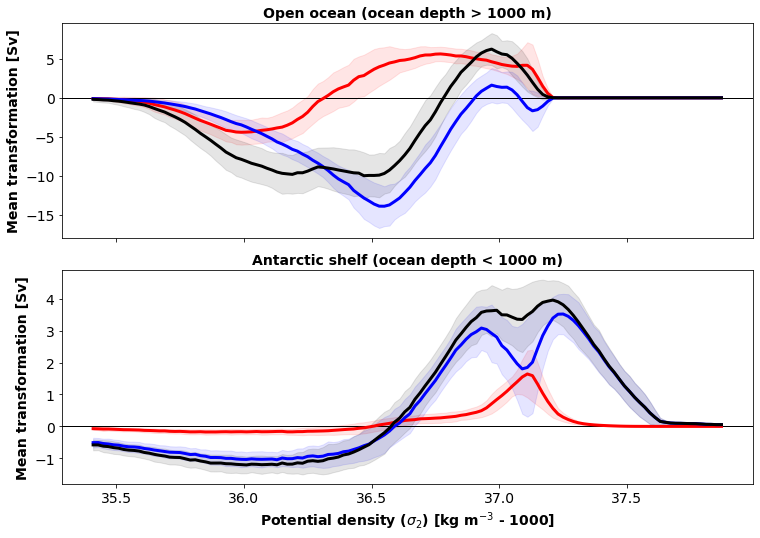

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.15)
cs = ['r','b','k']
for i, reg in enumerate(['offshr','onshlf']):
    
    axs[i].axhline(y=0, xmin=0, xmax=1, c = 'k', lw=1.0, ls='-')
    
    for j, ten in enumerate(['heat','salt','total']):
        axs[i].fill_between(dsG.coords[lstr], G_mean[reg+'_'+ten]-G_std[reg+'_'+ten], 
                            G_mean[reg+'_'+ten]+G_std[reg+'_'+ten], alpha=0.1, edgecolor=cs[j], facecolor=cs[j])
        axs[i].plot(dsG.coords[lstr], G_mean[reg+'_'+ten], lw=3, c=cs[j], ls='-',label=None)
        
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_ylabel('Mean transformation [Sv]',fontsize=14,fontweight='bold')
    
axs[0].set_xticklabels([])
axs[0].set_title('Open ocean (ocean depth > 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_title('Antarctic shelf (ocean depth < 1000 m)', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14,fontweight='bold')
plt.show()

In [20]:
from plot import hovmoeller

In [21]:
dsG = xr.open_dataset(outdir+fname)

G_ann = dsG.groupby('time.year').mean('time')*1e-6
G_anom = G_ann - G_ann.mean('year')

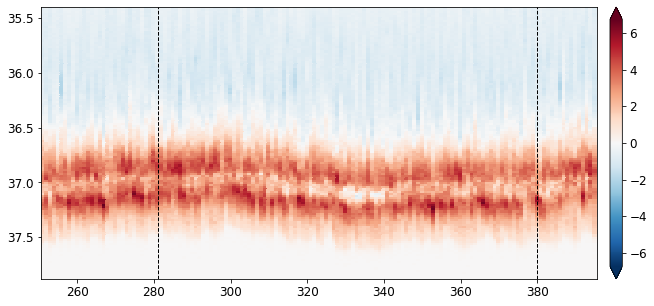

In [22]:
vstr = 'onshlf_salt'
fig = hovmoeller(G_ann[vstr], fsize=[12, 5], cmap='RdBu_r', yincrease=False,
                 vline=[int(yr_st),int(yr_ed)], hline=[32.57])

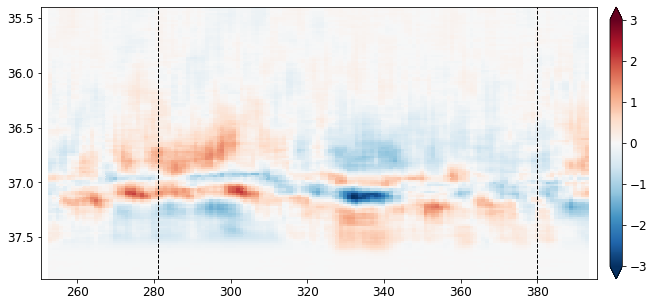

In [23]:
fig = hovmoeller(G_anom[vstr].rolling(year=5,center=True).mean(), fsize=[12, 5], 
                 cmap='RdBu_r', yincrease=False,vline=[int(yr_st),int(yr_ed)])

In [24]:
for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            ds = xr.open_zarr(file_path)
            
            if mod == 'CM4':
                subdir = 'CM4_piControl_C'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
            elif mod == 'ESM4':
                subdir = 'ESM4_piControl_D'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
                
            ds = preprocessing(ds, grid, decode_times=False, verbose=False)
            
            onshlf = ds.drop_dims('nv').where(shlf_mask==1,drop=True).where(ds.lat<north,drop=True)
            
            if north<-60:
                offshr = ds.drop_dims('nv').where(shlf_mask!=1,drop=True).where(ds.lat<north,drop=True)
            else:
                offshr = ds.drop_dims('nv')\
                            .where(xr.concat([shlf_mask, xr.zeros_like(ds.wet)\
                                              .isel(y=slice(len(shlf_mask.y), None))], 
                                             dim='y')!=1,drop=True).where(ds.lat<north,drop=True)
            onshlf['time_bnds'] = ds.time_bnds
            offshr['time_bnds'] = ds.time_bnds
            
            # Initialize 2D surface WMT class
            if 'lev' in list(ds.dims.keys()):
                dd_srf_onshlf = swmt(onshlf.drop_dims(['lev','lev_outer']))
                dd_srf_offshr = swmt(offshr.drop_dims(['lev','lev_outer']))
            else:
                dd_srf_onshlf = swmt(onshlf)
                dd_srf_offshr = swmt(offshr)
                
            dsG_onshlf = dd_srf_onshlf.G(lstr, bins=lbins, group_tend=False)
            dsG_onshlf['total'] = dsG_onshlf.heat+dsG_onshlf.salt
            dsG_offshr = dd_srf_offshr.G(lstr, bins=lbins, group_tend=False)
            dsG_offshr['total'] = dsG_offshr.heat+dsG_offshr.salt
            
            for vstr in list(dsG_onshlf.data_vars):
                dsG_onshlf = dsG_onshlf.rename({vstr:'onshlf_'+vstr})
                dsG_offshr = dsG_offshr.rename({vstr:'offshr_'+vstr})
            dsG = xr.merge([dsG_onshlf,dsG_offshr])
            
            head = '%s_%s_%s'%(mod,exp,str(mem))
            fname = head+'_so_%sto%s_southof%sS_%s_onvoffshelf_decomposed_%s_%s.nc'\
                        %(str(ds.time.dt.year[0].values).rjust(4, '0'),
                          str(ds.time.dt.year[-1].values).rjust(4, '0'),
                          str(abs(north)).replace('.',''), var, lstr, dl_str)
            print('Saving to file:', fname)
            with ProgressBar():
                dsG.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_antwater_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  6min 53.0s
Saving to file: CM4_antwater_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  4min 55.6s
Saving to file: CM4_antwater_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  4min 47.4s
Saving to file: CM4_stress_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  6min 50.0s
Saving to file: CM4_stress_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[########################################] | 100% Completed |  4min 45.2s
Saving to file: CM4_stress_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
[#############################

## Spatial maps of transformation

In [21]:
val = 36.95
dl = 0.1
dl_str = str(dl).replace('.','').ljust(3, '0')
reg='onshlf'
print(yr_st,yr_ed)

0281 0380


In [22]:
if reg=='onshlf':
    dsF = dd_srf_onshlf.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed,group_tend=False)
    F_tot = dd_srf_onshlf.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed)
elif reg=='offshr':
    dsF = dd_srf_offshr.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed,group_tend=False)
    F_tot = dd_srf_offshr.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed)

In [23]:
dsF['total'] = F_tot.reset_coords(drop=True)
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
fname = head+'_so_%sto%s_southof%sS_Fmap_%s_decomposed_%s_%s_at%s.nc'\
                %(yr_st,yr_ed,str(abs(north)).replace('.',''), 
                  reg, lstr, dl_str,('%.2f'%val).replace('.',''))
print('Saving to file:', fname)
with ProgressBar():
    dsF.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_control_so_0281to0380_southof600S_Fmap_onshlf_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  5min 14.4s


In [24]:
if reg=='onshlf':
    with ProgressBar():
        sig = dd_srf_onshlf.get_density(lstr)[2].sum('lev_outer')\
                .sel(time=slice(yr_st,yr_ed)).where(onshlf['wet']==1).load()
elif reg=='offshr':
    with ProgressBar():
        sig = dd_srf_offshr.get_density(lstr)[2].sum('lev_outer')\
                .sel(time=slice(yr_st,yr_ed)).where(offshr['wet']==1).load()

[########################################] | 100% Completed | 48.2s


In [25]:
if reg=='onshlf':
    onshlf['sig'] = sig[sig.time.dt.month==9].mean('time')
elif reg=='offshr':
    offshr['sig'] = sig[sig.time.dt.month==9].mean('time')

In [26]:
from plot import map_transformation_rate_so
from plot import cartopy_map_so

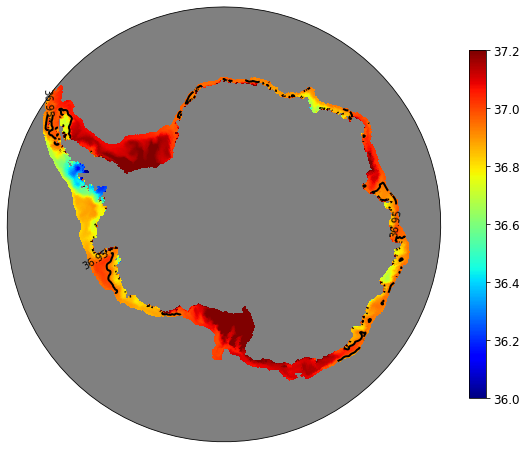

In [27]:
fig = cartopy_map_so(onshlf if reg=='onshlf' else offshr,'sig', varc = 'sig', lat=-60, cmap='jet', 
                     drawBath=False, levels=None, vrange=[36,37.2],
                     clfmt='%1.2f', clevels=[36.95], clf=10, clw=2,ccol='k')

In [28]:
dsF = xr.open_dataset(outdir+fname)

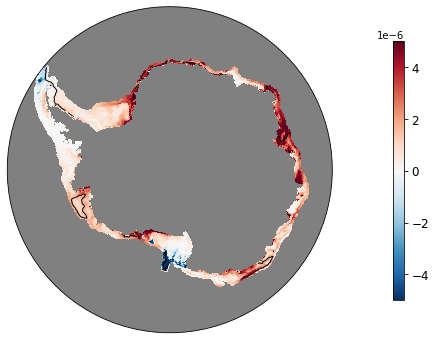

In [29]:
fig = map_transformation_rate_so(dsF.total, onshlf if reg=='onshlf' else offshr, sig, val, month=[11], fsize=[8,6],
                                 draw_Mean=False, lat=-60, vrange=[-5e-6,5e-6])

In [46]:
for mod in ['CM4', 'ESM4']:
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            file_path = os.path.join(zarrdir,'zarr',mod,exp,str(mem),'monthly')
            ds = xr.open_zarr(file_path)
            
            if mod == 'CM4':
                subdir = 'CM4_piControl_C'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
            elif mod == 'ESM4':
                subdir = 'ESM4_piControl_D'
                grid = xr.open_dataset(rootdir+subdir+'/'+pp+'/'+pp+'.static.nc')
                shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
                
            ds = preprocessing(ds, grid, decode_times=False, verbose=False)
            
            if reg=='onshlf':
                ds_reg = ds.drop_dims('nv').where(shlf_mask==1,drop=True).where(ds.lat<north,drop=True)
            elif reg=='offshr':
                if north<-60:
                    ds_reg = ds.drop_dims('nv').where(shlf_mask!=1,drop=True).where(ds.lat<north,drop=True)
                else:
                    ds_reg = ds.drop_dims('nv')\
                            .where(xr.concat([shlf_mask, xr.zeros_like(ds.wet)\
                                              .isel(y=slice(len(shlf_mask.y), None))], 
                                             dim='y')!=1,drop=True).where(ds.lat<north,drop=True)
            else:
                print('ERROR: Region string unknown')
                continue
            ds_reg['time_bnds'] = ds.time_bnds
            
            # Initialize 2D surface WMT class
            if 'lev' in list(ds.dims.keys()):
                dd_srf = swmt(ds_reg.drop_dims(['lev','lev_outer']))
            else:
                dd_srf = swmt(ds_reg)
                
            if mod=='CM4':
                if exp=='control':
                    yr_st,yr_ed = '0281','0380'
                else:
                    yr_st,yr_ed = '0051','0070'
            elif mod=='ESM4':
                if exp=='control':
                    yr_st,yr_ed = '0121','0220'
                elif mem=='101':
                    yr_st,yr_ed = '0151','0170'
                else:
                    yr_st,yr_ed = '0051','0070'
            print(yr_st,yr_ed)
            dsF = dd_srf.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed,group_tend=False)
            F_tot = dd_srf.isosurface_mean(lstr, val, dl = dl, ti=yr_st, tf=yr_ed)
            dsF['total'] = F_tot.reset_coords(drop=True)
            head = '%s_%s_%s'%(mod,exp,str(mem))
            fname = head+'_so_%sto%s_southof%sS_Fmap_%s_decomposed_%s_%s_at%s.nc'\
                        %(yr_st,yr_ed,str(abs(north)).replace('.',''), 
                          reg, lstr, dl_str,('%.2f'%val).replace('.',''))
            print('Saving to file:', fname)
            with ProgressBar():
                dsF.reset_coords(drop=True).to_netcdf(outdir+fname, format='NETCDF4')

0051 0070
Saving to file: CM4_antwater_251_so_0051to0070_southof600S_Fmap_onshlf_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  3.1s
0051 0070
Saving to file: CM4_antwater_290_so_0051to0070_southof600S_Fmap_onshlf_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  3.4s
0051 0070
Saving to file: CM4_antwater_332_so_0051to0070_southof600S_Fmap_onshlf_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  3.0s
0051 0070
Saving to file: CM4_stress_251_so_0051to0070_southof600S_Fmap_onshlf_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  2.2s
0051 0070
Saving to file: CM4_stress_290_so_0051to0070_southof600S_Fmap_onshlf_decomposed_sigma2_010_at3695.nc
[########################################] | 100% Completed |  1min  5.6s
0051 0070
Saving to file: CM4_stress_332_so_0051to0070_southof600S_Fm